In [1]:
from f_data_prep import *
from f_drosophila_infer import *
from f_train import *

In [2]:
data_complete = np.loadtxt('../data_complete.txt')
data_bin = np.vsplit(data_complete, 6)
data_init = np.vstack([data_bin[i] for i in range(5)])
data_diff = make_data_diff(data_complete, 6)

In [6]:
def infer_train_test(X, y, kf=10):
    kfold = KFold(n_splits=kf, shuffle=False, random_state=1)
    
    error_list=[]
    w_list=[]
    sigma_list=[]
    bias_list=[]
    for (tr_ind, te_ind) in (kfold.split(y)):
        X_tr, y_tr = X[tr_ind], y[tr_ind]
        X_te, y_te = X[te_ind], y[te_ind]
        
        y_te_sum_sq = np.sum(np.abs(y_te)**2, axis=0)
        w, sigma, bias = infer_drosophila(X_tr, y_tr, max_iter=1000, power=3)
        y_pred = odd_power(bias + X_te.dot(w), 3) + sigma*npr.normal(size=(1,99))
        error = np.sqrt(np.sum(np.abs(y_te - y_pred)**2, axis=0)/y_te_sum_sq)
        error_list.append(error)
        w_list.append(w)
        sigma_list.append(sigma)
        bias_list.append(bias)
    return [np.mean(error_list, axis=0), np.std(error_list, axis=0), w_list, sigma_list, bias_list]

In [7]:
X, y = shuffle(data_init, data_diff)
infer_list = infer_train_test(X, y, kf=10)

with open('./pickles/infer_list_power3.pkl', 'wb') as f:
    pickle.dump(infer_list, f)

In [8]:
with open('./pickles/infer_list_power3.pkl', 'rb') as f:
    infer_list = pickle.load(f)

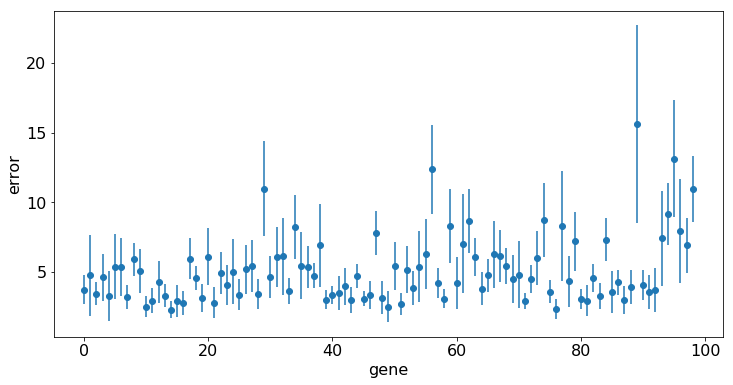

In [9]:
plt.figure(figsize=(12,6))
plt.rcParams['font.size'] = 16
plt.errorbar(range(99), infer_list[0], yerr=infer_list[1], fmt='o')
plt.xlabel('gene')
plt.ylabel('error')
plt.show()